## Setup & Imports

In [1]:
import numpy as np
import random 

from tqdm import tqdm
import glob

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

/pfs/data5/home/tu/tu_tu/tu_zxoau27/penv/lib64/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights
from torchvision import models

In [3]:
from torchvision.models.segmentation.fcn import _fcn_resnet
from torchgeo.models import resnet, resnet50

from torchgeo.datasets import LoveDA

### GPU

In [4]:
!nvidia-smi

Wed Feb 15 17:55:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:B3:00.0 Off |                    0 |
| N/A   36C    P0    42W / 300W |      9MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## UNet Model

In [5]:
# double convolutional layer which is executed in every step of the u-net 
# conv layer takes as input number of input channels -> in_channels and outputs vice versa
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    # forward pass in the conv layer 
    def forward(self, x):
        return self.conv(x)

# design complete u-net shape 
# model takes as default 3 input channels and 6 output channels
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=6, features=[64, 128, 256, 512],  # features -> num of input nodes at every stage in the model 
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):  # reverse the features i.o. to move upwards in the model 
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        # lowest stage in u-net 
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # final conv layer: takes in 64 channels and outputs 1 channel by default 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    # forward pass of the u-net model between stages 
    def forward(self, x):
        skip_connections = []  # red arrows in the model representation 

        for down in self.downs:
            x = down(x)  # one DoubleConv run-through 
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

## Data Import and Preprocessing

In [6]:
# Path to shared workspace -> path where data is stored
path='/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/LoveDA'

In the following the LoveDA dataset is downloaded and stored under the path variable. By calling the dataset class the data is imported and ready to use. 

In [7]:
love_train = LoveDA(
    root=path, 
    split='train', 
    scene=['urban', 'rural'], 
    transforms=None, 
    download=True, 
    checksum=False)

love_val = LoveDA(
    root=path, 
    split='val', 
    scene=['urban', 'rural'], 
    transforms=None, 
    download=True, 
    checksum=False)

print(f"""
      Train data: {len(love_train)}
      Validation data: {len(love_val)}
      """)

train
Files already downloaded and verified
val
Files already downloaded and verified

      Train data: 2522
      Validation data: 1669
      


### Looking at the data

In [8]:
# Get a random index 
rand_idx = random.randint(0, len(love_train))

# Call a random sample from the dataset
img = love_train[rand_idx]['image'].to(torch.uint8)
mask = love_train[rand_idx]['mask']

**Original Labels**:

- unknown - 0
- background – 1
- building – 2
- road – 3
- water – 4
- barren – 5
- forest – 6
- agriculture – 7

In [9]:
%%script echo skipping 
RGB_classes = [
       (0, 0, 0),
       (255, 255, 225),
       (255,  0, 255),
       (255, 0, 0),
       (0,  0,  255), 
       (128, 128, 128),
       (0, 130, 0),
       (255, 200, 0)]

skipping


#### Change mask labels

In [10]:
# Merge class water, barren into class background
mask[(mask == 4) | (mask == 5)] = 1

Change classes since weight biasing requires sequrntial label indices

In [11]:
# Change class forest (6) to (4)
mask[mask == 6] = 4
# Change class agriculture (7) to (5)
mask[mask == 7] = 5

**New Labels**:

- unknown - 0
- background (water, barren) – 1
- building – 2
- road – 3
- forest – 4
- agriculture – 5

In [12]:
RGB_classes = [
       (0, 0, 0),
       (255, 255, 225),
       (255,  0, 255),
       (255, 0, 0),
       (0, 130, 0),
       (255, 200, 0)]

# Create a dictionary to translate a mask to a rgb tensor
idx2rgb = {key: value for key, value in enumerate(RGB_classes)}

In [13]:
# Create the RGB tensor
rgb_tensor = torch.zeros((img.shape), dtype=torch.uint8)
for index in idx2rgb:
    for channel, color in enumerate(idx2rgb[index]):
        rgb_tensor[channel][mask == index] = color

In [14]:
# Function to transform tensor to image
transform = torchvision.transforms.ToPILImage()

In [15]:
image = transform(img).convert('RGB')
mask_img = transform(rgb_tensor)

### Display random sample

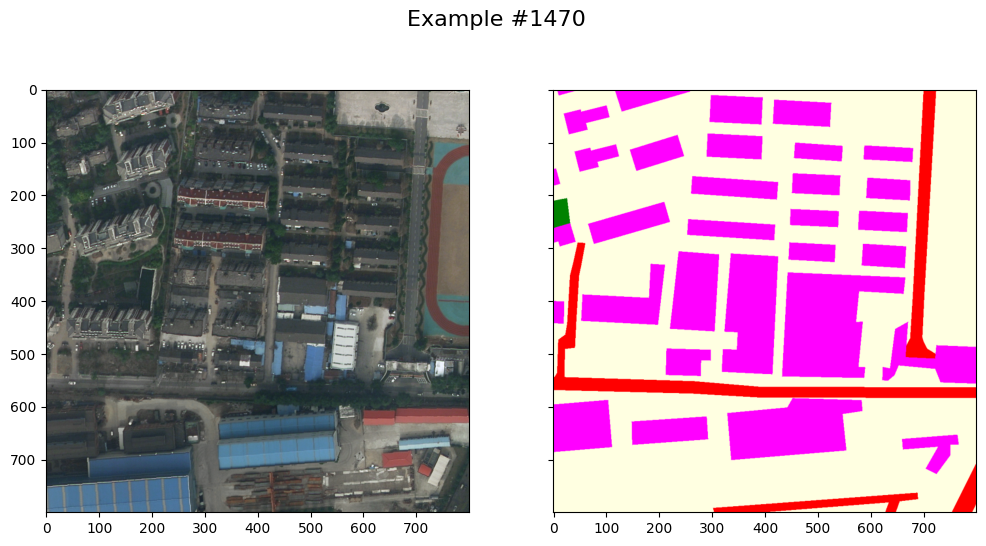

In [16]:
SIZE = 800

im1 = image.resize((SIZE, SIZE))
im2 = mask_img.resize((SIZE, SIZE))

f, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)

f.suptitle(f"Example #{rand_idx}", fontsize=16)
plt.show()

## Utilitiy Functions

### Transformers

In [17]:
def train_transforms(sample, image_size):
    """Apply transforms on training sample from data set. This function is called within the dataset class. It takes a 
    sample of the form Dict[str: tensor, str: tensor] as an input as well as an integer for the image_size."""
    
    # Specify transforms for training 
    train_transform = A.Compose([
        A.Resize(
            height=image_size, 
            width=image_size),
        A.Flip(p=0.5),
        A.Normalize(
            mean=(0.485, 0.456, 0.406), 
            std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ],)
    
    mask = sample['mask']
    
    # Merge class water (4), barren (5) into class background (1)
    mask[(mask == 4) | (mask == 5)] = 1
    # Change class forest (6) to (4)
    mask[mask == 6] = 4
    # Change class agriculture (7) to (5)
    mask[mask == 7] = 5
  
    # transform function expects numpy array of the form (W, H, C)
    image = np.array(sample['image'].permute(1, 2, 0))
    mask = np.array(mask)

    # Apply transforms on image and mask 
    augmented = train_transform(image=image, mask=mask)
    image = augmented['image']
    mask = augmented['mask']

    return {'image': image, 'mask': mask}


def val_transforms(sample, image_size):
    """Apply transforms on validation sample from data set. This function is called within the dataset class. It takes a 
    sample of the form Dict[str: tensor, str: tensor] as an input as well as an integer for the image_size."""
    
    # Specify transforms for validation
    val_transform = A.Compose([
        A.Resize(
            height=image_size, 
            width=image_size),
        A.Normalize(
            mean=(0.485, 0.456, 0.406), 
            std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ],)
    
    mask = sample['mask']
    
    # Merge class water (4), barren (5) into class background (1)
    mask[(mask == 4) | (mask == 5)] = 1
    # Change class forest (6) to (4)
    mask[mask == 6] = 4
    # Change class agriculture (7) to (5)
    mask[mask == 7] = 5
  
    # transform function expects numpy array of the form (W, H, C)
    image = np.array(sample['image'].permute(1, 2, 0))
    mask = np.array(mask)

    # Apply transforms on image and mask 
    augmented = val_transform(image=image, mask=mask)
    image = augmented['image']
    mask = augmented['mask']

    return {'image': image, 'mask': mask}

### Data Loader

In [18]:
def get_loaders(
    path,
    batch_size,
    image_size,
    num_workers = 2,
    pin_memory = True,
):
    """Call the dataset class and the data loader. Function takes as an input the batch size and the image size
    which will be used in the transform functions. Number of workers is 2 by default and pin memory is true."""

    # Load training dataset 
    train_data = LoveDA(
        root=path, 
        split='train', 
        scene=['urban', 'rural'], 
        transforms=lambda sample: train_transforms(sample, image_size), 
        download=False, 
        checksum=False,)

    # Initialize data loader for training dataset
    train_loader = DataLoader(
            train_data,
            batch_size = batch_size,
            num_workers = num_workers,
            pin_memory = pin_memory,
            shuffle=True,)
    
    # Load validation dataset 
    val_data = LoveDA(
        root=path, 
        split='val', 
        scene=['urban', 'rural'], 
        transforms=lambda sample: val_transforms(sample, image_size), 
        download=False, 
        checksum=False,)

    # Initialize data loader for validation dataset
    val_loader = DataLoader(
            val_data,
            batch_size = batch_size,
            num_workers = num_workers,
            pin_memory = pin_memory,
            shuffle=True,)
  
    return train_loader, val_loader

### Evaluation

In [19]:
def check_accuracy(loader, model, pretrained=False, device="cuda"):
  """Compute the prediction accuracy of a model. Takes a loader as input as well as a pre-defined model. 
  Pretrained is a boolean specifying which type of model is used."""
  
  num_correct = 0
  num_pixels = 0

  model.eval()
  with torch.no_grad():
      for batch in loader:
          x = batch['image'].to(device)
          y = batch['mask']
          
          # Compute probabilities
          if pretrained:
            # Pretrained model from torch.models (requires ['out'])
            probs = torch.nn.Softmax(model(x)['out'])
          else:
            # Self written UNet
            probs = torch.nn.Softmax(model(x))
          
          # Get predictions by choosing highest probability 
          preds = torch.argmax(probs.dim, axis=1).cpu()
          num_correct += (preds == y).sum().item()
          num_pixels += torch.numel(preds)

  print(
      f"Got {num_correct}/{num_pixels} pixels correct with acc {num_correct/num_pixels*100:.2f}"
  )

### Save & Load Model

In [25]:
def save_checkpoint(state, filename="weights/love_checkpoint_DLV3biased.pth.tar"):
    """Save a model to the filename argument."""
    
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model):
    """Load a model from checkpoint."""
    
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

## Training

### Hyperparameter

In [26]:
# Specify number of classes for segmentation task
OUTPUT_CHANNELS = 6

# Hyperparameters
LEARNING_RATE = 5e-5
BATCH_SIZE = 8
NUM_EPOCHS = 2

IMAGE_SIZE = 800  # 1024 originally

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
PIN_MEMORY = True

# Specify model
PRETRAINED = True
GEO_PRETRAINED = False
FREEZE = False # if True -> only train last layer

### Train Function

In [27]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  """Training function. Iterates through every batch within the given loader. Takes as input a pre-defined model as 
  well as the optimizer and the loss function."""
  
  loss_sum = 0.0
  loop = tqdm(loader, desc="Training")
  
  model.train()
  for batch_idx, batch in enumerate(loop):
  
    data = batch['image'].type(torch.float).to(device=DEVICE)
    targets = batch['mask'].type(torch.LongTensor).to(device=DEVICE)

    # Forward pass
    with torch.cuda.amp.autocast():
      if PRETRAINED or GEO_PRETRAINED:
        # Pretrained model from torch.models (requires ['out'])
        predictions = model(data)['out']
      else:
        # Self written UNet
        predictions = model(data)

      # Compute batch loss
      loss = loss_fn(predictions, targets)

    # Backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    # Comupte loss sum and count batches
    loss_sum += loss.item()
    batch_idx += 1

    # Update loop every 5 batches
    if not batch_idx % 5:
      loop.set_postfix(loss=loss_sum/(batch_idx))

### Train Loop

In [28]:
def main():
    """Function calls the train function and the validation function. 
    It organizes the training process.
    
    (1) Initialize data loader 
    (2) Define model: 
        1. DeepLabv3_Resnet101 pretrained on COCO dataset (task: segmentation)
            - train all layer or only output layer 
        2. ResNet50 pretrained on Sentinel2 data (task: classification)
            - train all layer or only output layer 
        3. UNet (task: segmentation)
            - only train all layer
        
    (3) Define loss function and optimizer
        - within the loss function the weights of the different labels can be biased
    
    (4) Run through all epochs:
        1. Train model and update weights 
        2. Save model checkpoints 
        3. Evaluate model - compute accuracy after each epoch
    """

    # Initialize the data loader
    train_loader, val_loader = get_loaders(
        path=path,
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,)
  
    # Load pre-trained DeepLapV3 ResNet101
    if PRETRAINED:
        MODEL = models.segmentation.deeplabv3_resnet101(
            weights=DeepLabV3_ResNet101_Weights.DEFAULT)
        MODEL.classifier = DeepLabHead(2048, OUTPUT_CHANNELS)
        MODEL.aux_classifier = None

    # Load pre-trained ResNet50
    elif GEO_PRETRAINED:
        weights_backbone = resnet.ResNet50_Weights.SENTINEL2_RGB_SECO
        backbone = resnet50(weights=weights_backbone)
        MODEL = _fcn_resnet(backbone, OUTPUT_CHANNELS, aux=False)

    # Load UNet-Model
    else: 
        MODEL = UNET(in_channels=3, out_channels=OUTPUT_CHANNELS)

    # Train only classifier (last layer)
    if PRETRAINED or GEO_PRETRAINED:
        if FREEZE:
            for name, param in MODEL.named_parameters():
                if "classifier" not in name:
                    param.requires_grad = False

    MODEL = MODEL.to(device=DEVICE)

    # Class weights for multi-class classification
    # 0 - unknown, 
    # 1 - background (incl. water, barren), 
    # 2 - building, 
    # 3 - road, 
    # 4 - forest, 
    # 5 - agriculture
    weights = [1.0, 0.9, 1.0, 1.0, 1.2, 1.2]
    class_weights = torch.FloatTensor(weights).cuda()

    CRITERION = nn.CrossEntropyLoss(weight=class_weights).to(device=DEVICE)
    OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)

    SCALER = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        print(f"Start epoch: {epoch+1}")
        
        # Train model
        train_fn(train_loader, MODEL, OPTIMIZER, CRITERION, SCALER)
        
        # save model
        checkpoint = {
            "state_dict": MODEL.state_dict(),
            "optimizer": OPTIMIZER.state_dict(),
        }
        save_checkpoint(checkpoint)
        
        # check accuracy
        pre = PRETRAINED or GEO_PRETRAINED
        check_accuracy(val_loader, MODEL, pretrained=pre, device=DEVICE)
        
        print(f"End epoch: {epoch+1} \n")

### Run Train Loop

In [29]:
# Train DeepLab3 ResNet101
print(f"Cuda available: {torch.cuda.is_available()}")
main()

Cuda available: True
train
val
Start epoch: 1


Training: 100%|██████████| 316/316 [13:28<00:00,  2.56s/it, loss=0.765]


=> Saving checkpoint
Got 805466271/1068160000 pixels correct with acc 75.41
End epoch: 1 

Start epoch: 2


Training: 100%|██████████| 316/316 [13:28<00:00,  2.56s/it, loss=0.547]


=> Saving checkpoint
Got 799212771/1068160000 pixels correct with acc 74.82
End epoch: 2 



### Predictions

In [43]:
if PRETRAINED:
  trained_model = models.segmentation.deeplabv3_resnet101()

  # More than last classifier layer

  trained_model.classifier = DeepLabHead(2048, OUTPUT_CHANNELS)
  trained_model.aux_classifier = None
  trained_model = trained_model.to(device='cuda')

  load_checkpoint(torch.load("weights/love_checkpoint_DLV3biased.pth.tar"), trained_model)
  
elif GEO_PRETRAINED:
  
  backbone = resnet50()
  trained_model = _fcn_resnet(backbone, OUTPUT_CHANNELS, aux=False)
  trained_model = trained_model.to(device='cuda')
  load_checkpoint(torch.load("love_checkpoint_RN50unbiased.pth.tar"), trained_model)
  
else: 
  trained_model = UNET(in_channels=3, out_channels=OUTPUT_CHANNELS).to(device='cuda')
  load_checkpoint(torch.load("love_checkpoint_DLV3_60acc.pth.tar"), trained_model)

=> Loading checkpoint


In [44]:
def predictions(image, model, image_size, device):
    
    img = image.permute(1, 2, 0).cpu().numpy()
    
    val_transform = A.Compose([
        A.Resize(
            height=image_size, 
            width=image_size),
        A.Normalize(
            mean=(0.485, 0.456, 0.406), 
            std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        ],)
    
    img = val_transform(image=img)['image'].unsqueeze(0).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        
        predictions = model(img)['out']
        pred_labels = torch.argmax(predictions, axis=1).cpu().squeeze(0)
        
        # Create the RGB tensor
        rgb_tensor = torch.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=torch.uint8)
        for index in idx2rgb:
            rgb_tensor[pred_labels == index] = torch.tensor(idx2rgb[index], dtype=torch.uint8)
            
        rgb_tensor = rgb_tensor.permute(2, 0, 1)
        
        return rgb_tensor

In [45]:
set_idx = 100
image = love_train[set_idx]['image'].to(torch.uint8)
img = transform(image).convert('RGB')

prediction = predictions(
        image, 
        trained_model, 
        IMAGE_SIZE, 
        DEVICE)

pred_mask = transform(prediction)

In [46]:
mask = love_train[set_idx]['mask']

# Merge class water, barren into class background
mask[(mask == 4) | (mask == 5)] = 1
# Change class forest (6) to (4)
mask[mask == 6] = 4
# Change class agriculture (7) to (5)
mask[mask == 7] = 5

In [47]:
# Create the RGB tensor
rgb_tensor = torch.zeros((1024, 1024, 3), dtype=torch.uint8)
for index in idx2rgb:
    rgb_tensor[mask == index] = torch.tensor(idx2rgb[index], dtype=torch.uint8)
    
rgb_tensor = rgb_tensor.permute(2, 0, 1)

mask = transform(rgb_tensor)

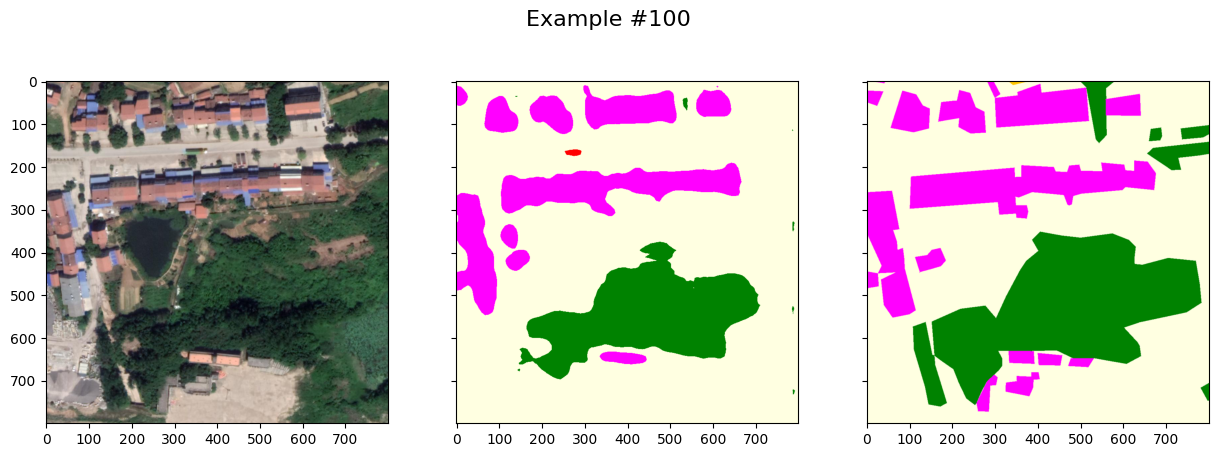

In [48]:
SIZE = 800

im1 = img.resize((SIZE, SIZE))
im2 = pred_mask.resize((SIZE, SIZE))
im3 = mask.resize((SIZE, SIZE))

f, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[2].imshow(im3)

f.suptitle(f"Example #{set_idx}", fontsize=16)
plt.show()

critical image: /pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/raw/BB_ML_0121_2016-05-02.jpg

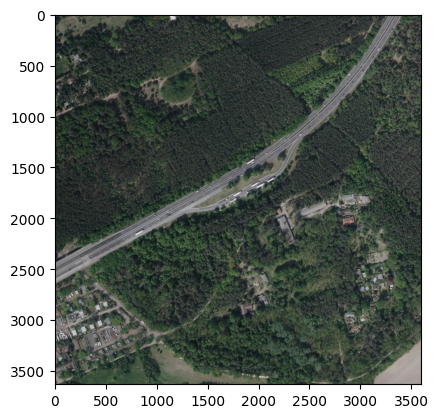

In [140]:
data_path = "/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/raw/BB_ML_0049_2018-05-05.jpg"
input_img = Image.open(data_path)

plt.imshow(input_img)
plt.show()

In [130]:
img_arr = np.array(input_img.convert("RGB"))
img_arr.shape

(3850, 3830, 3)

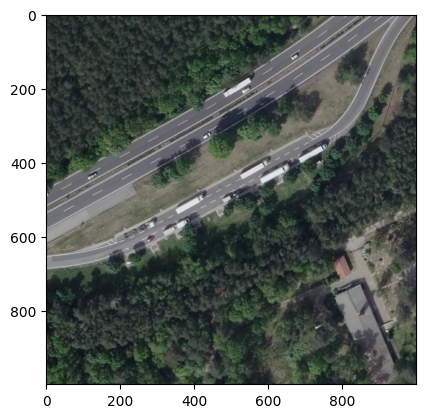

In [141]:
# Setting the cordinates for cropped image
x_left = 1400
x_right = x_left + 1000

y_top = 1250
y_bottom = y_top + 1000

# Cropped image of above dimension
# (It will not change original image)
input_img_cropped = input_img.crop((x_left, y_top, x_right, y_bottom))

plt.imshow(input_img_cropped)
plt.show()

In [142]:
img_tensor = torch.from_numpy((np.asarray(input_img_cropped))).permute(2, 0, 1)

In [143]:
prediction = predictions(
        img_tensor, 
        trained_model, 
        IMAGE_SIZE, 
        DEVICE)

pred_mask = transform(prediction)

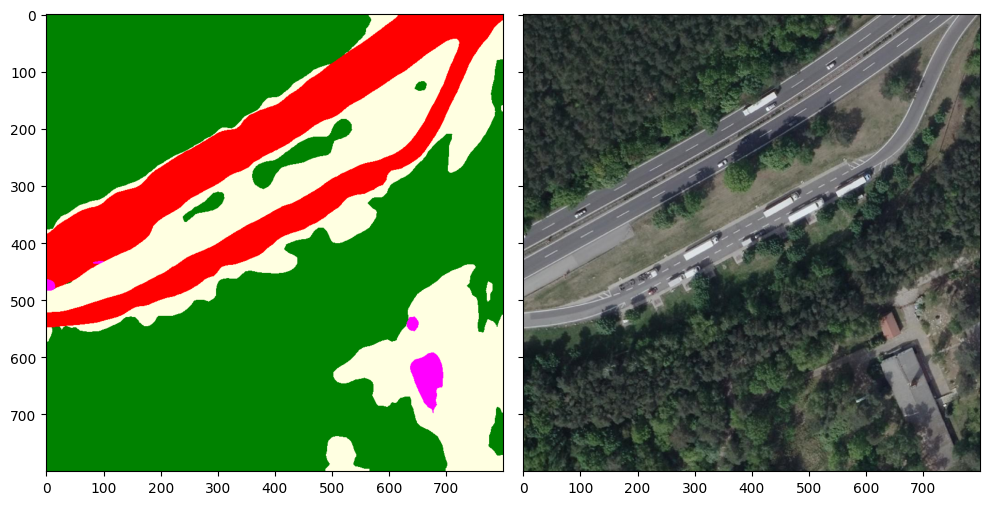

In [144]:
im1 = pred_mask.resize((IMAGE_SIZE, IMAGE_SIZE))
im2 = input_img_cropped.resize((IMAGE_SIZE, IMAGE_SIZE))

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1)
ax[1].imshow(im2)

f.tight_layout()
plt.show()